In [116]:
import re
import random
import pandas as pd
import hashlib

In [117]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [118]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Lost in a Good Book, Fforde",33.829199,11.276400,16.902239,3
Terraform Codebox,270.589524,5.522235,24.312937,49
Pandas,391.765481,43.529498,98.778269,9
Power BI,423.507658,12.833565,32.936289,33
Terraform,688.579578,68.857958,192.976463,10
DAX,724.690680,80.521187,263.379974,9
Azure DevOps Pipelines,804.982277,80.498228,171.914200,10
CCH Axcess,899.488099,31.016831,71.403788,29
Azure Functions + PP365,1032.475651,73.748261,125.611179,14
TSQL,1583.327867,65.971994,180.614576,24


# Histogram

sum of ages: ~42802.42


<Axes: >

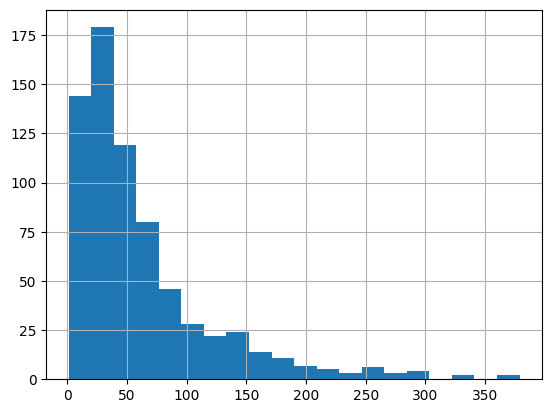

In [119]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~42802.42


<Axes: >

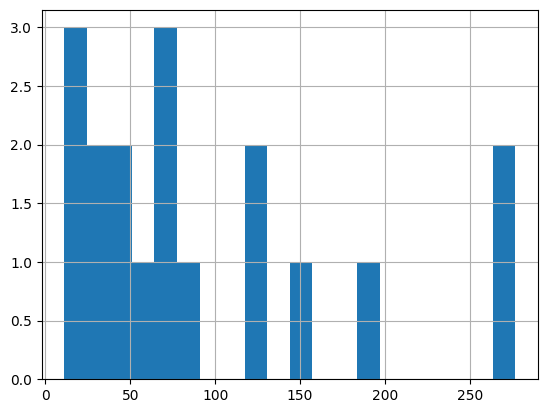

In [120]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='PowerShell Modules']['age'].hist(bins=20)

# Completely Random Shuffle

In [121]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [122]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [123]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [124]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [125]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [126]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [127]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [128]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [129]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 699
Total card age: 42802.42


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
232,PowerShell Modules,New-AzResourceGroup\n\nDefinition: Creates a n...,c0e68e58a2e41f56e0f36d35b5d6fb0f,-276.675578,-92.413803,276.675578,1663.448461,0.776287,18,0,0
469,PowerShell Modules,Module Conflicts\n\nDefinition: Situations whe...,b1c3faa6a5749b8ab2e1f48ea517b0e8,-152.739094,-92.413803,276.675578,1663.448461,0.776287,18,3,0
235,PowerShell Modules,Get-Module -ListAvailable\n\nDefinition: Lists...,ac5d724a5fa2bac4ebb9cd5743d95931,-86.829891,-92.413803,276.675578,1663.448461,0.776287,18,6,0
236,PowerShell Modules,Az Module\n\nDefinition: A module for managing...,49771a588dddc1647bb2c56ec18094e7,-64.528029,-92.413803,276.675578,1663.448461,0.776287,18,9,0
238,PowerShell Modules,Update-Module\n\nDefinition: A cmdlet used to ...,cb38c075a0d7effece2aabf74a58d1f3,-39.059886,-92.413803,276.675578,1663.448461,0.776287,18,12,0
475,PowerShell Modules,PowerShell Module\n\nDefinition: A package tha...,7b43eec001675e3d34313073b6c55297,-20.962328,-92.413803,276.675578,1663.448461,0.776287,18,15,0
2,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,-378.925010,-89.591156,378.925010,2777.325837,0.436475,31,0,0
3,FSLogix,During a user's session when the connection to...,5a231d0eed5713489976f99e2e931c2e,-209.011935,-89.591156,378.925010,2777.325837,0.436475,31,3,0
4,FSLogix,Q: What happens to a FSLogix Profile Container...,62462ed42de4668ad697865f418384c6,-105.066601,-89.591156,378.925010,2777.325837,0.436475,31,6,0
483,FSLogix,FSLogix Cloud Cache:\nA caching mechanism with...,f33b58e322721e23d71e0554fd1859ab,-96.388063,-89.591156,378.925010,2777.325837,0.436475,31,9,0


## Age Max

In [130]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [131]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [132]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [133]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
2,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,-378.925010,-89.591156,378.925010,2777.325837,0.436475,31,0,0
51,Azure Compute Gallery,SAS Token (Shared Access Signature) – A tempor...,16543cefaf9d760fb4860bf0a6fcb4bb,-364.483848,-75.804411,364.483848,2501.545574,0.815775,33,0,0
13,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,-337.607861,-81.523278,337.607861,2690.268176,0.104897,33,0,0
245,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,-322.486471,-89.591156,378.925010,2777.325837,0.436475,31,1,1
105,JavaScript Concepts,Using Object.keys() with for...of Loop: The Ob...,06c15a040f743007e381b243ccc3d915,-299.079102,-64.921349,299.079102,4349.730413,0.257654,67,0,0
43,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-292.921714,-77.711323,292.921714,1865.071753,0.193683,24,0,0
481,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-291.657736,-89.591156,378.925010,2777.325837,0.436475,31,2,2
128,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-288.394326,-64.231096,288.394326,3404.248074,0.073060,53,0,0
146,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-282.142673,-63.689011,282.142673,3184.450559,0.955887,50,0,0
232,PowerShell Modules,New-AzResourceGroup\n\nDefinition: Creates a n...,c0e68e58a2e41f56e0f36d35b5d6fb0f,-276.675578,-92.413803,276.675578,1663.448461,0.776287,18,0,0


In [134]:
existing_cards['age'].mean()

-61.23378847062164